<a href="https://colab.research.google.com/github/bytehub-ai/code-examples/blob/main/tutorial/06_timeseries_forecasting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ByteHub Feature Store: Timeseries forecasting example

This notebook demo shows how a feature store can simplify a timeseries forecasting project. This example is based on Tensorflow's [timeseries forecasting tutorial](https://www.tensorflow.org/tutorials/structured_data/time_series), using a [weather dataset](https://www.bgc-jena.mpg.de/wetter/) from the [Max Planck Institute for Biogeochemistry](https://www.bgc-jena.mpg.de/).


In [1]:
!pip install -q bytehub

In [2]:
import pandas as pd
import numpy as np
import os
import shutil
import bytehub as bh
import tensorflow as tf
from datetime import datetime
print(f'ByteHub version {bh.__version__}')

ByteHub version 0.3.4


In [3]:
# Remove any previously created feature stores
try:
    os.remove('bytehub.db')
except FileNotFoundError:
    pass
try:
    shutil.rmtree('/tmp/featurestore/tutorial')
except FileNotFoundError:
    pass

Create a new featurestore - this will be stored in a local sqlite database named `bytehub.db`.

In [4]:
fs = bh.FeatureStore()

Next, create a namespace called `tutorial` to store some features in. Edit the url field to specify a local file storage location that you would like to use. Feature values will be saved within this folder using parquet format.

In [5]:
fs.create_namespace(
    'tutorial', url='/tmp/featurestore/tutorial', description='Timeseries forecasting tutorial'
)

## Loading raw data

Fetch the weather dataset and load it to the feature store.

In [6]:
zip_path = tf.keras.utils.get_file(
    origin='https://storage.googleapis.com/tensorflow/tf-keras-datasets/jena_climate_2009_2016.csv.zip',
    fname='jena_climate_2009_2016.csv.zip',
    extract=True)
csv_path, _ = os.path.splitext(zip_path)

In [7]:
df = pd.read_csv(csv_path)
df.head()

,Date Time,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),wv (m/s),max. wv (m/s),wd (deg)
0,01.01.2009 00:10:00,996.52,-8.02,265.40,-8.90,93.3,3.33,3.11,0.22,1.94,3.12,1307.75,1.03,1.75,152.3
1,01.01.2009 00:20:00,996.57,-8.41,265.01,-9.28,93.4,3.23,3.02,0.21,1.89,3.03,1309.80,0.72,1.50,136.1
2,01.01.2009 00:30:00,996.53,-8.51,264.91,-9.31,93.9,3.21,3.01,0.20,1.88,3.02,1310.24,0.19,0.63,171.6
3,01.01.2009 00:40:00,996.51,-8.31,265.12,-9.07,94.2,3.26,3.07,0.19,1.92,3.08,1309.19,0.34,0.50,198.0
4,01.01.2009 00:50:00,996.51,-8.27,265.15,-9.04,94.1,3.27,3.08,0.19,1.92,3.09,1309.00,0.32,0.63,214.3


In [8]:
# Create ByteHub features and timestamp index
df = df.rename(columns={'Date Time': 'time'})
df = df.assign(time=df['time'].apply(lambda x: datetime.strptime(x, '%d.%m.%Y %H:%M:%S'))).set_index('time')
for col in df.columns:
  name = 'raw.' + ''.join(col.split(' ')[:-1])
  unit = col.split(' ')[-1][1:-1]
  df = df.rename(columns={col: 'tutorial/' + name})
  # Use feature metadata to store the unit information
  fs.create_feature('tutorial/' + name, partition='year', meta={'unit': unit})
# Save data to feature store
fs.save_dataframe(df)

In [9]:
fs.list_features()

,namespace,name,version,description,meta,partition,serialized,transform
0,tutorial,raw.p,1,,{'unit': 'mbar'},year,False,False
1,tutorial,raw.T,1,,{'unit': 'degC'},year,False,False
2,tutorial,raw.Tpot,1,,{'unit': 'K'},year,False,False
3,tutorial,raw.Tdew,1,,{'unit': 'degC'},year,False,False
4,tutorial,raw.rh,1,,{'unit': '%'},year,False,False
5,tutorial,raw.VPmax,1,,{'unit': 'mbar'},year,False,False
6,tutorial,raw.VPact,1,,{'unit': 'mbar'},year,False,False
7,tutorial,raw.VPdef,1,,{'unit': 'mbar'},year,False,False
8,tutorial,raw.sh,1,,{'unit': 'g/kg'},year,False,False
9,tutorial,raw.H2OC,1,,{'unit': 'mmol/mol'},year,False,False


## Cleaning data

Following [this step](https://www.tensorflow.org/tutorials/structured_data/time_series#wind_velocity) we can use a feature transform to remove the `-9999` values from wind velocity.

In [10]:
@fs.transform('tutorial/cleaned.wv', from_features=['tutorial/raw.wv'])
def clean_wind_data(df):
  bad_data = df['tutorial/raw.wv'] < 0
  df.loc[bad_data, 'tutorial/raw.wv'] = 0
  return df

@fs.transform('tutorial/cleaned.max.wv', from_features=['tutorial/raw.max.wv'])
def clean_wind_data(df):
  bad_data = df['tutorial/raw.max.wv'] < 0
  df.loc[bad_data, 'tutorial/raw.max.wv'] = 0
  return df 

In [11]:
# Verify that the data has been cleaned: minimum of the cleaned data should now be zero
data = fs.load_dataframe(['tutorial/raw.wv', 'tutorial/raw.max.wv', 'tutorial/cleaned.wv', 'tutorial/cleaned.max.wv'])
data.describe()

,tutorial/raw.wv,tutorial/raw.max.wv,tutorial/cleaned.wv,tutorial/cleaned.max.wv
count,420224.000000,420224.000000,420224.000000,420224.000000
mean,1.700930,3.054884,2.129230,3.530774
std,65.472111,69.043660,1.540641,2.338168
min,-9999.000000,-9999.000000,0.000000,0.000000
25%,0.990000,1.760000,0.990000,1.760000
50%,1.760000,2.960000,1.760000,2.960000
75%,2.860000,4.730000,2.860000,4.730000
max,28.490000,23.500000,28.490000,23.500000


## Feature engineering

Following [this step](https://www.tensorflow.org/tutorials/structured_data/time_series#feature_engineering) we can create new features for:
* Wind x- and y-components, calculated from wind speed and angle;
* Cyclical sin- and cos-variables from time. 

In [12]:
@fs.transform('tutorial/transformed.wind-x', from_features=['tutorial/cleaned.wv', 'tutorial/raw.wd'])
def wind_x(df):
  radians = df['tutorial/raw.wd'] * np.pi / 180
  return df['tutorial/cleaned.wv'] * np.cos(radians)

@fs.transform('tutorial/transformed.wind-y', from_features=['tutorial/cleaned.wv', 'tutorial/raw.wd'])
def wind_y(df):
  radians = df['tutorial/raw.wd'] * np.pi / 180
  return df['tutorial/cleaned.wv'] * np.sin(radians)

In [13]:
# Verify the new wind x- and y-features
data = fs.load_dataframe(['tutorial/cleaned.wv', 'tutorial/raw.wd', 'tutorial/transformed.wind-x', 'tutorial/transformed.wind-y'])
data.head()

,tutorial/cleaned.wv,tutorial/raw.wd,tutorial/transformed.wind-x,tutorial/transformed.wind-y
time,,,,
2009-01-01 00:10:00,1.03,152.3,-0.911955,0.478787
2009-01-01 00:20:00,0.72,136.1,-0.518797,0.499249
2009-01-01 00:30:00,0.19,171.6,-0.187962,0.027756
2009-01-01 00:40:00,0.34,198.0,-0.323359,-0.105066
2009-01-01 00:50:00,0.32,214.3,-0.264351,-0.180328


In [14]:
# Do the same for max wind speed
@fs.transform('tutorial/transformed.maxwind-x', from_features=['tutorial/cleaned.max.wv', 'tutorial/raw.wd'])
def wind_x(df):
  radians = df['tutorial/raw.wd'] * np.pi / 180
  return df['tutorial/cleaned.max.wv'] * np.cos(radians)

@fs.transform('tutorial/transformed.maxwind-y', from_features=['tutorial/cleaned.max.wv', 'tutorial/raw.wd'])
def wind_y(df):
  radians = df['tutorial/raw.wd'] * np.pi / 180
  return df['tutorial/cleaned.max.wv'] * np.sin(radians)

In [15]:
# Create transforms for sin and cos of day
@fs.transform('tutorial/transformed.day.sine', from_features=['tutorial/raw.wd'])
def sine_days(df):
  # Convert time index to seconds
  seconds = df.index.astype(np.int64) // 10 ** 9
  days = seconds / 24 / 60 / 60
  return pd.DataFrame({'value': np.sin(days.values)}, index=df.index)

@fs.transform('tutorial/transformed.day.cosine', from_features=['tutorial/raw.wd'])
def cosine_days(df):
  # Convert time index to seconds
  seconds = df.index.astype(np.int64) // 10 ** 9
  days = seconds / 24 / 60 / 60
  return pd.DataFrame({'value': np.cos(days.values)}, index=df.index)

In [16]:
# Do the same for year
@fs.transform('tutorial/transformed.year.sine', from_features=['tutorial/raw.wd'])
def sine_days(df):
  # Convert time index to seconds
  seconds = df.index.astype(np.int64) // 10 ** 9
  years =  seconds / 24 / 60 / 60 / 365.2425
  return pd.DataFrame({'value': np.sin(years.values)}, index=df.index)

@fs.transform('tutorial/transformed.year.cosine', from_features=['tutorial/raw.wd'])
def cosine_days(df):
  # Convert time index to seconds
  seconds = df.index.astype(np.int64) // 10 ** 9
  years =  seconds / 24 / 60 / 60 / 365.2425
  return pd.DataFrame({'value': np.cos(years.values)}, index=df.index)

In [17]:
data = fs.load_dataframe(['tutorial/transformed.day.sine', 'tutorial/transformed.day.cosine', 'tutorial/transformed.year.sine', 'tutorial/transformed.year.cosine'])
data.head()

,tutorial/transformed.day.sine,tutorial/transformed.day.cosine,tutorial/transformed.year.sine,tutorial/transformed.year.cosine
time,,,,
2009-01-01 00:10:00,0.855157,0.518370,0.964195,0.265193
2009-01-01 00:20:00,0.858736,0.512419,0.964200,0.265174
2009-01-01 00:30:00,0.862274,0.506443,0.964205,0.265156
2009-01-01 00:40:00,0.865770,0.500443,0.964211,0.265138
2009-01-01 00:50:00,0.869224,0.494418,0.964216,0.265119


In [18]:
# List all of our newly engineered features
fs.list_features(regex=r'transformed\..')

,namespace,name,version,description,meta,partition,serialized,transform
16,tutorial,transformed.wind-x,1,,{},date,False,True
17,tutorial,transformed.wind-y,1,,{},date,False,True
18,tutorial,transformed.maxwind-x,1,,{},date,False,True
19,tutorial,transformed.maxwind-y,1,,{},date,False,True
20,tutorial,transformed.day.sine,1,,{},date,False,True
21,tutorial,transformed.day.cosine,1,,{},date,False,True
22,tutorial,transformed.year.sine,1,,{},date,False,True
23,tutorial,transformed.year.cosine,1,,{},date,False,True


## Model development

Now that the feature store is handling all of our data-prep and feature engineering, it is easy to query the features we want, resample appropriately, and feed into an ML model.

Here we will build a model to forecast the temperature feature, `raw.T` into the future using hourly sampling.

In [19]:
# Define the features we want to use in our model
model_features = [
  'tutorial/raw.T', # We will be forecasting this variable
  'tutorial/raw.p',
  'tutorial/raw.Tpot',
  'tutorial/raw.Tdew',
  'tutorial/raw.rh',
  'tutorial/raw.VPmax',
  'tutorial/raw.VPact',
  'tutorial/raw.VPdef',
  'tutorial/raw.sh',
  'tutorial/raw.H2OC',
  'tutorial/raw.rho',
  'tutorial/cleaned.wv',
  'tutorial/cleaned.max.wv',
  'tutorial/transformed.wind-x',
  'tutorial/transformed.wind-y',
  'tutorial/transformed.maxwind-x',
  'tutorial/transformed.maxwind-y',
  'tutorial/transformed.day.sine',
  'tutorial/transformed.day.cosine',
  'tutorial/transformed.year.sine',
  'tutorial/transformed.year.cosine'
]

In [20]:
# Prepare a dataset of these features, resampled hourly
all_df = fs.load_dataframe(model_features, freq='1h', from_date='2009-01-01 01:00')

In [21]:
all_df.head()

,tutorial/raw.T,tutorial/raw.p,tutorial/raw.Tpot,tutorial/raw.Tdew,tutorial/raw.rh,tutorial/raw.VPmax,tutorial/raw.VPact,tutorial/raw.VPdef,tutorial/raw.sh,tutorial/raw.H2OC,tutorial/raw.rho,tutorial/cleaned.wv,tutorial/cleaned.max.wv,tutorial/transformed.wind-x,tutorial/transformed.wind-y,tutorial/transformed.maxwind-x,tutorial/transformed.maxwind-y,tutorial/transformed.day.sine,tutorial/transformed.day.cosine,tutorial/transformed.year.sine,tutorial/transformed.year.cosine
2009-01-01 01:00:00,-8.05,996.50,265.38,-8.78,94.4,3.33,3.14,0.19,1.96,3.15,1307.86,0.21,0.63,-0.204862,-0.046168,-0.614587,-0.138503,0.872637,0.488370,0.964221,0.265101
2009-01-01 02:00:00,-8.88,996.62,264.54,-9.77,93.2,3.12,2.90,0.21,1.81,2.91,1312.25,0.25,0.63,-0.245971,-0.044701,-0.619848,-0.112645,0.892222,0.451597,0.964251,0.264991
2009-01-01 03:00:00,-8.81,996.84,264.59,-9.66,93.5,3.13,2.93,0.20,1.83,2.94,1312.18,0.18,0.63,-0.175527,0.039879,-0.614344,0.139576,0.910259,0.414040,0.964281,0.264881
2009-01-01 04:00:00,-9.05,996.99,264.34,-10.02,92.6,3.07,2.85,0.23,1.78,2.85,1313.61,0.10,0.38,-0.050000,-0.086603,-0.190000,-0.329090,0.926715,0.375764,0.964311,0.264771
2009-01-01 05:00:00,-9.63,997.46,263.72,-10.65,92.2,2.94,2.71,0.23,1.69,2.71,1317.19,0.40,0.88,-0.368202,0.156292,-0.810044,0.343843,0.941563,0.336836,0.964341,0.264661


In [22]:
# Create train (70%), validation (20%) and test (10%) sets
n = len(all_df)

train_df = all_df[0:int(n * 0.7)]
val_df = all_df[int(n * 0.7):int(n * 0.9)]
test_df = all_df[int(n * 0.9):]

print(f'Split {n} records into {len(train_df)} for train, {len(val_df)} for validation, {len(test_df)} for test')

Split 70128 records into 49089 for train, 14026 for validation, 7013 for test


Now define a Tensorflow model to do the forecasting. Here we are going to build an LSTM that takes a 24 hour sequence of weather data and predicts one step into the future.

In [23]:
# Use this function to make windowed views of the data
def make_dataset(features, targets, sequence_length=24, shuffle=False, batch_size=1):
  ds = tf.keras.preprocessing.timeseries_dataset_from_array(
      features[:-sequence_length], targets[sequence_length:], sequence_length, batch_size=batch_size, shuffle=shuffle
  )
  return ds

In [24]:
# Training and validation datasets
train_ds = make_dataset(train_df, train_df[['tutorial/raw.T']], shuffle=True, batch_size=32)
val_ds = make_dataset(val_df, val_df[['tutorial/raw.T']], shuffle=False, batch_size=32)

In [25]:
# Define LSTM model
def build_model(df):
  # Fit a normalisation layer on the input data
  norm = tf.keras.layers.experimental.preprocessing.Normalization()
  # Add an extra dimension to the normalisation (this will be used for the time sequences)
  norm.adapt(df.values[:, np.newaxis, :])
  lstm_model = tf.keras.models.Sequential(
      [
       # Normalisation
       norm,
       tf.keras.layers.LSTM(32, return_sequences=False),
       tf.keras.layers.Dense(units=1)
      ]
  )
  return lstm_model

In [26]:
# Function to compile and fit model
def compile_and_fit(model, train_ds, val_ds, patience=2):
  early_stopping = tf.keras.callbacks.EarlyStopping(
      monitor='val_loss', patience=patience, mode='min'
  )

  model.compile(
      loss=tf.losses.MeanSquaredError(),
      optimizer=tf.optimizers.Adam(),
      metrics=[tf.metrics.MeanAbsoluteError()]
  )

  history = model.fit(
      train_ds,
      epochs=100,
      validation_data=val_ds,
      callbacks=[early_stopping]
  )
  return history

In [27]:
# Builds the model, with normalisation constants based on training set
model = build_model(train_df)

In [28]:
history = compile_and_fit(model, train_ds, val_ds)

Epoch 1/100
1533/1533 [==============================] - 17s 9ms/step - loss: 37.5097 - mean_absolute_error: 3.8785 - val_loss: 1.7050 - val_mean_absolute_error: 0.8437
Epoch 2/100
1533/1533 [==============================] - 13s 9ms/step - loss: 1.2896 - mean_absolute_error: 0.7325 - val_loss: 0.8083 - val_mean_absolute_error: 0.6279
Epoch 3/100
1533/1533 [==============================] - 13s 9ms/step - loss: 0.7156 - mean_absolute_error: 0.5749 - val_loss: 0.6144 - val_mean_absolute_error: 0.5489
Epoch 4/100
1533/1533 [==============================] - 13s 8ms/step - loss: 0.5792 - mean_absolute_error: 0.5260 - val_loss: 0.5541 - val_mean_absolute_error: 0.5171
Epoch 5/100
1533/1533 [==============================] - 13s 8ms/step - loss: 0.5413 - mean_absolute_error: 0.5098 - val_loss: 0.5220 - val_mean_absolute_error: 0.5038
Epoch 6/100
1533/1533 [==============================] - 13s 8ms/step - loss: 0.5239 - mean_absolute_error: 0.5008 - val_loss: 0.5267 - val_mean_absolute_error

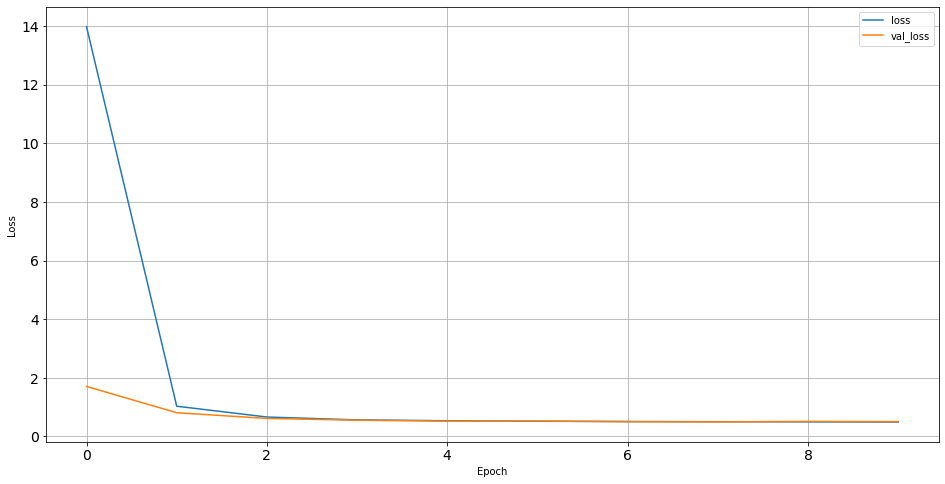

In [29]:
# Plot train, validation losses
history_df = pd.DataFrame(history.history)
_ = history_df.plot(y=['loss', 'val_loss'], figsize=(16, 8), grid=True, xlabel='Epoch', ylabel='Loss', fontsize=14)

## Evaluation

Try using the model with data from the test set. We'll compare the LSTM model we have trained with a simple baseline 'persistence' model, which simply predicts the next temperature value to be the same as the previous one.

In [30]:
# Don't shuffle the test data, so that we can plot it sequentially
test_ds = make_dataset(test_df, test_df[['tutorial/raw.T']], shuffle=False, batch_size=1)

In [31]:
# Define a baseline persistence model (next temperature value = last temperature value in input sequence)
baseline_model = tf.keras.models.Sequential(
    [
     # Shape [batch, time, features]
     # Take the last time value, and the first feature (temperature variable)
     tf.keras.layers.Lambda(lambda x: x[:,-1,0:1])
    ]
)
baseline_model.compile(loss=tf.losses.MeanSquaredError(), metrics=[tf.metrics.MeanAbsoluteError()])

In [32]:
test_loss, test_mae = model.evaluate(test_ds)

6966/6966 [==============================] - 16s 2ms/step - loss: 0.4707 - mean_absolute_error: 0.4857


In [33]:
baseline_loss, baseline_mae = baseline_model.evaluate(test_ds)

6966/6966 [==============================] - 11s 2ms/step - loss: 1.1394 - mean_absolute_error: 0.7791


Good news! The LSTM model outperforms the simple baseline on the test dataset.

Now create a plot of actual vs predicted temperature values on a sample of the test data.

In [34]:
result = []
for sample in test_ds.take(24 * 3): # 3 days of predictions
  X, y = sample
  # Forecast using LSTM
  predicted = model.predict(X)
  baseline = baseline_model.predict(X)
  actual = y.numpy()
  result.append({'LSTM': predicted.flatten()[0], 'Baseline': baseline.flatten()[0], 'Actual': actual.flatten()[0]})
result = pd.DataFrame(result)

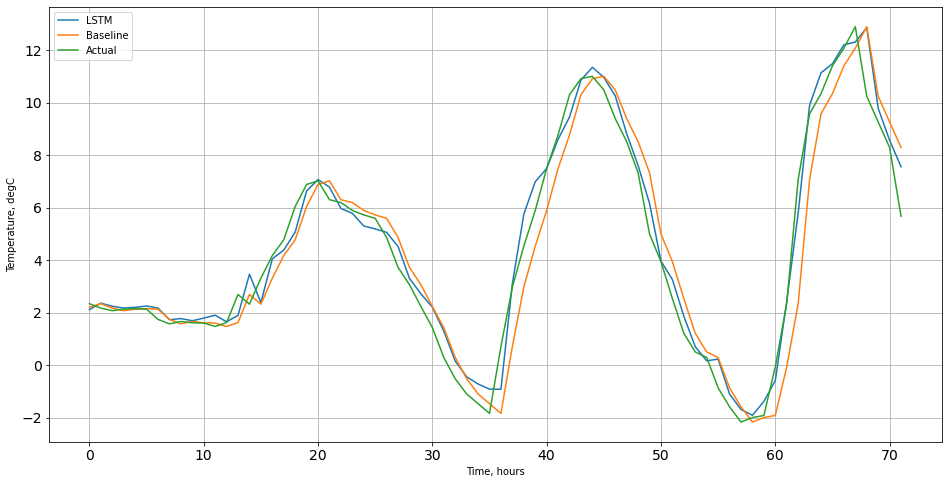

In [35]:
_ = result.plot(y=['LSTM', 'Baseline', 'Actual'], figsize=(16, 8), grid=True, xlabel='Time, hours', ylabel='Temperature, degC', fontsize=14)